In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d

ann_arr = load_model('IP_Arrival_time/Arrival_ANN_1')
ann_end = load_model('IP_End_time/End_ANN_2')
ann_chg = load_model('IP_Change_time/Change_ANN_3')

#Section1
ann1 = load_model('IP_Section_1_new/Section1_ANN_3')
sc1 = pickle.load(open('IP_Section_1_new/Section1_scaler_ANN_3.pkl', 'rb'))
#Section2
ann2 = load_model('IP_Section_2_new/Section2_new_ANN_5')
sc2 = pickle.load(open('IP_Section_2_new/Section2_new_scaler_ANN_5.pkl', 'rb'))
#Section3
ann3 = load_model('IP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('IP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('IP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('IP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('IP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('IP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('IP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('IP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

In [2]:
charge_mass = 16.2
standoff_distance = 1.7
start_time = 0
#termination_time = 130
interval = 0.01

In [3]:
arr = np.array ([[charge_mass,standoff_distance]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
print ("arrival", arrival_time,"end", end_time, "change", change_time)
termination_time = end_time +50

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:3] = sc1.transform(d_set[:,0:3])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:3] = sc2.transform(d_set[:,0:3])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:3] = sc3.transform(d_set[:,0:3])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:3] = sc4.transform(d_set[:,0:3])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:3] = sc5.transform(d_set[:,0:3])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:3] = sc6.transform(d_set[:,0:3])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

if termination_time < arrival_time:
    start = start_time
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = start_time
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(charge_mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(standoff_distance, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)

p2, section = p_fluctuation(standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
print (section)

X1 = ml_model[:,0]
y1_int = ml_model[:,1]
y1 = y1_int + 101.25

1/1 [==============================] - 0s 116ms/step
arrival [[0.707708]] end [[34.597286]] change [[1.4689693]]


C:\Users\z5379606\AppData\Local\Temp\ipykernel_26428\2167176811.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = np.arange(start, end + interval, interval)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_26428\2167176811.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2= np.arange(arrival_time, end_time + interval, interval)


106/106 [==============================] - 1s 3ms/step
1


In [ ]:
file_path = f'G:/Chamodi/Machine_Learning/Pressure_history_2/IP_Num&ANN_Comparison/LSDYNA/{charge_mass}kg/{standoff_distance}m.xlsx'
lsdyna = pd.read_excel(file_path)
#lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])
X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']
X2_original=X2_original*1000
y2_original=(y2_original/1000)

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2 = X2_original[index1:index2+1]
y2 = y2_original[index1:index2+1]

X2 = X2.to_numpy()
y2 = y2.to_numpy()

y2_int = y2 - 101.25

print("Numerical length",len(y2), "ANN-based length", len(y1))

In [ ]:
# Perform numerical integration using the trapezoidal rule
area_num = np.trapz(y2_int, X2)
area_ann = np.trapz(y1_int, X1)
print(f"Integrated Area Under the Curve: {area_num}, {area_ann}")

# Perform cumulative integration using the trapezoidal rule
ci_num = np.cumsum(np.gradient(X2) * y2_int)
ci_ann = np.cumsum(np.gradient(X1) * y1_int)

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.rcParams["font.family"] = "Times New Roman"

# Plot the original data (y vs time) on the primary y-axis
ax1.plot(X2, y2, color = 'blue',label = 'Numerical - Overpressure', linewidth=4)
ax1.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework - Overpressure', linewidth=3)
ax1.set_xlabel('Time (ms)', fontsize = 30)
ax1.set_ylabel('Incident Pressue (kPa)', fontsize = 30)
ax1.tick_params(axis='both', labelsize = 30)
ax1.set_xticks([60,70,80,90,100,110])
ax1.set_yticks([96,100,104,108,112])
ax1.set_xlim(start_time,termination_time)
#ax1.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2), fontsize=30, ncol=1, frameon = False)

# Create a secondary y-axis for the cumulative integration
ax2 = ax1.twinx()
ax2.plot(X2, ci_num, color='green', linestyle='dotted',label='Numerical - Impulse', linewidth=3)
ax2.plot(X1, ci_ann, linestyle='dashdot', label='ANN framework - Impulse', color='orange', linewidth=3)
ax2.set_ylabel('Impulse (Pa.s)', fontsize = 30)
ax2.set_yticks([-10,0,10,20,30,40])
ax2.tick_params(axis='both', labelsize = 30)
#ax2.legend(loc='upper center', bbox_to_anchor=(0.3, -0.45), fontsize=30, ncol=1, frameon = False)

plt.savefig(f'IP_Num&ANN_Comparison/Images2/Section{section}/{standoff_distance}m{charge_mass}kg_new2.png', dpi=150, bbox_inches='tight')
plt.show()

2.7097000275
34.597286224365234 119.99999731999999
Shape of X: (8464,)
Shape of y: (8464,)
Shape of X: (12002,)
Shape of y: (12002,)


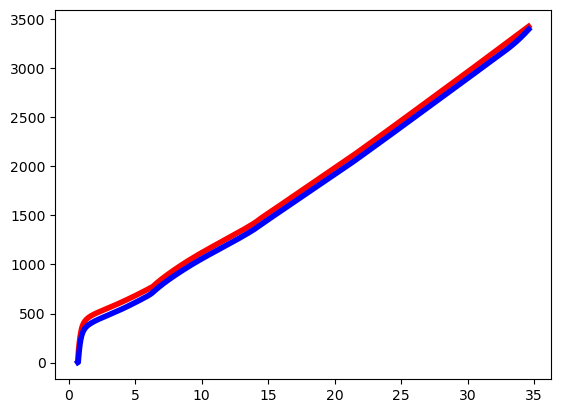

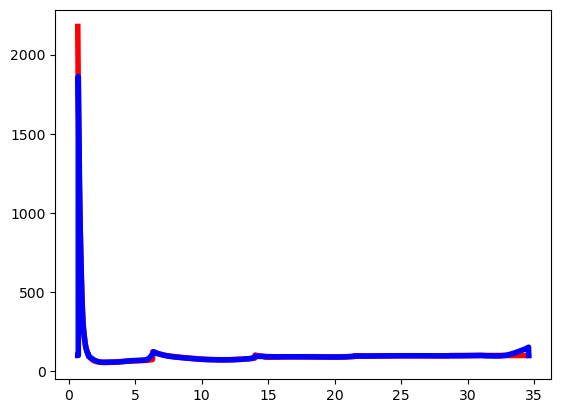

0.551037570578005
ann_auc= 3394.276453357208
num_auc= 3413.0838275623987


In [4]:
file_path = f'G:/Chamodi/Machine_Learning/Pressure_history_2/IP_Num&ANN_Comparison/LSDYNA/{charge_mass}kg/{standoff_distance}m.xlsx'
lsdyna = pd.read_excel(file_path)
#lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])
X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']
X2_original = (X2_original * 1000).to_numpy()
y2_original = (y2_original / 1000).to_numpy()

def boundary_search(X,y):
    start_time = None
    end_time_bs = None
    start_index = np.argmax(y)
    start_time = X[start_index]
    zero_index1 = next((i for i, val in enumerate(y[start_index:], start=0) if val <= 101.25), None)
    if isinstance (zero_index1, int):
       zero_index1 = zero_index1 + start_index
       min_index = np.argmin(y[zero_index1:])+zero_index1
       zero_index2 = next((i for i, val in enumerate(y[min_index:], start=0) if val < 101.25), None)
       if isinstance (zero_index2, int):
           end_index = zero_index2 + min_index
           end_time_bs = X[end_index]
       else:
           end_time_bs = X[-1]
    else:
        print('zero_index1 error')
    return start_time, end_time_bs

start_time_num, end_time_num = boundary_search(X2_original,y2_original)

start_time_ann = float(arrival_time[0][0])
end_time_ann = float(end_time[0][0])
start_time_overall = min(start_time_num, start_time_ann)
end_time_overall = max(end_time_num, end_time_ann)
end_time_overall = min(end_time_overall, X2_original[-1])
print (end_time_overall, X2_original[-1])
def auc_cal(X,y, start_time, end_time):
    dataset = pd.DataFrame(X, columns=['Time'])
    dataset['Pressure'] = y
    filtered_data = dataset[(dataset['Time'] >= start_time) & (dataset['Time'] <= end_time)]
    # Extract time and pressure values
    time_values = filtered_data['Time'].values
    pressure_values = filtered_data['Pressure'].values
    
    # Integrate using the trapezoidal rule
    integration_result = np.trapz(pressure_values, time_values)
    auc_series = np.cumsum(np.gradient(time_values) * pressure_values)
    
    return integration_result, auc_series, time_values, pressure_values

ann_auc, ann_auc_series, ann_time, ann_pressure = auc_cal(X1,y1, start_time_overall, end_time_overall)
num_auc, num_auc_series, num_time, num_pressure = auc_cal(X2_original,y2_original, start_time_overall, end_time_overall)

fig_auc = plt.plot(figsize=(6, 6))

plt.plot(num_time, num_auc_series, color = 'red',label = 'Numerical', linewidth=4)
plt.plot(ann_time, ann_auc_series, color = 'blue',label = 'ANN', linewidth=4)
plt.show()

fig_auc2 = plt.plot(figsize=(6, 6))

plt.plot(num_time, num_pressure, color = 'red',label = 'Numerical', linewidth=4)
plt.plot(ann_time, ann_pressure, color = 'blue',label = 'ANN', linewidth=4)
plt.show()

error = (abs(ann_auc-num_auc)/num_auc)*100
print(error)
print ('ann_auc=',ann_auc)
print ('num_auc=',num_auc)

In [ ]:
# Numerical
max_index_num = np.argmax(y2)

zero_crossing_index = next((i for i, val in enumerate(y2[max_index_num:], start=0) if val <= 101.25), None)

if isinstance (zero_crossing_index, int):
    zero_crossing_index = zero_crossing_index+max_index_num
    change_time_num = X2[zero_crossing_index]
    positive_duration_num = change_time_num - X2[max_index_num]
    min_index_num = np.argmin(y2[zero_crossing_index:])+zero_crossing_index
    negative_peak_pressure_num = y2[min_index_num]
    negative_peak_time_num = X2[min_index_num]
    
    zero_crossing_index2 = next((i for i, val in enumerate(y2[min_index_num:], start=0) if val >= 101.25), None)
    
    if isinstance((zero_crossing_index2, zero_crossing_index) , int):
        zero_crossing_index2 = zero_crossing_index2+min_index_num
        end_time_num = X2[zero_crossing_index2]
        negative_duration_num = end_time_num - change_time_num
    else:
        negative_duration_num = max(X2)-change_time_num
else:
    positive_duration_num = None

if 'negative_peak_pressure_num' not in globals():
    negative_peak_pressure_num = None
if 'negative_peak_time_num' not in globals():
    negative_peak_time_num = None

positive_peak_pressure_num = y2[max_index_num]
positive_peak_time_num = X2[max_index_num]


# ANN-based
positive_duration_ann = float(change_time - arrival_time)
negative_duration_ann = float(end_time - change_time)

max_index_ann = np.argmax(y1)

a_zero_crossing_index = next((i for i, val in enumerate(y1[max_index_ann:], start=0) if val <= 101.25), None)

if isinstance (a_zero_crossing_index, int):
    a_zero_crossing_index = a_zero_crossing_index+max_index_ann
    min_index_ann = np.argmin(y1[a_zero_crossing_index:])+a_zero_crossing_index
    negative_peak_pressure_ann = y1[min_index_ann]
    negative_peak_time_ann = X1[min_index_ann]

if 'negative_peak_pressure_ann' not in globals():
    negative_peak_pressure_ann = None
if 'negative_peak_time_ann' not in globals():
    negative_peak_time_ann = None

positive_peak_pressure_ann = y1[max_index_ann]
positive_peak_time_ann = X1[max_index_ann]

def per_diff(value1, value2):
    per_dif = (abs(value1-value2)/value1)*100
    return per_dif

print('positive peak pressure- n', positive_peak_pressure_num, 'a', positive_peak_pressure_ann,'%', per_diff(positive_peak_pressure_num,positive_peak_pressure_ann))
print('negative peak pressure- n', negative_peak_pressure_num, 'a', negative_peak_pressure_ann,'%', per_diff(negative_peak_pressure_num,negative_peak_pressure_ann))
print('positive peak time- n', positive_peak_time_num, 'a', positive_peak_time_ann, '%', per_diff(positive_peak_time_num, positive_peak_time_ann))
print('negative peak time-n', negative_peak_time_num, 'a', negative_peak_time_ann, '%', per_diff(negative_peak_time_num, negative_peak_time_ann))
print('positive duration-n', positive_duration_num, 'a', positive_duration_ann, '%', per_diff(positive_duration_num, positive_duration_ann))
print('negative duration-n', negative_duration_num, 'a', negative_duration_ann, '%', per_diff(negative_duration_num, negative_duration_ann))
print('peak impulse-n', max(ci_num), 'a', max(ci_ann), '%', per_diff(max(ci_num), max(ci_ann)))